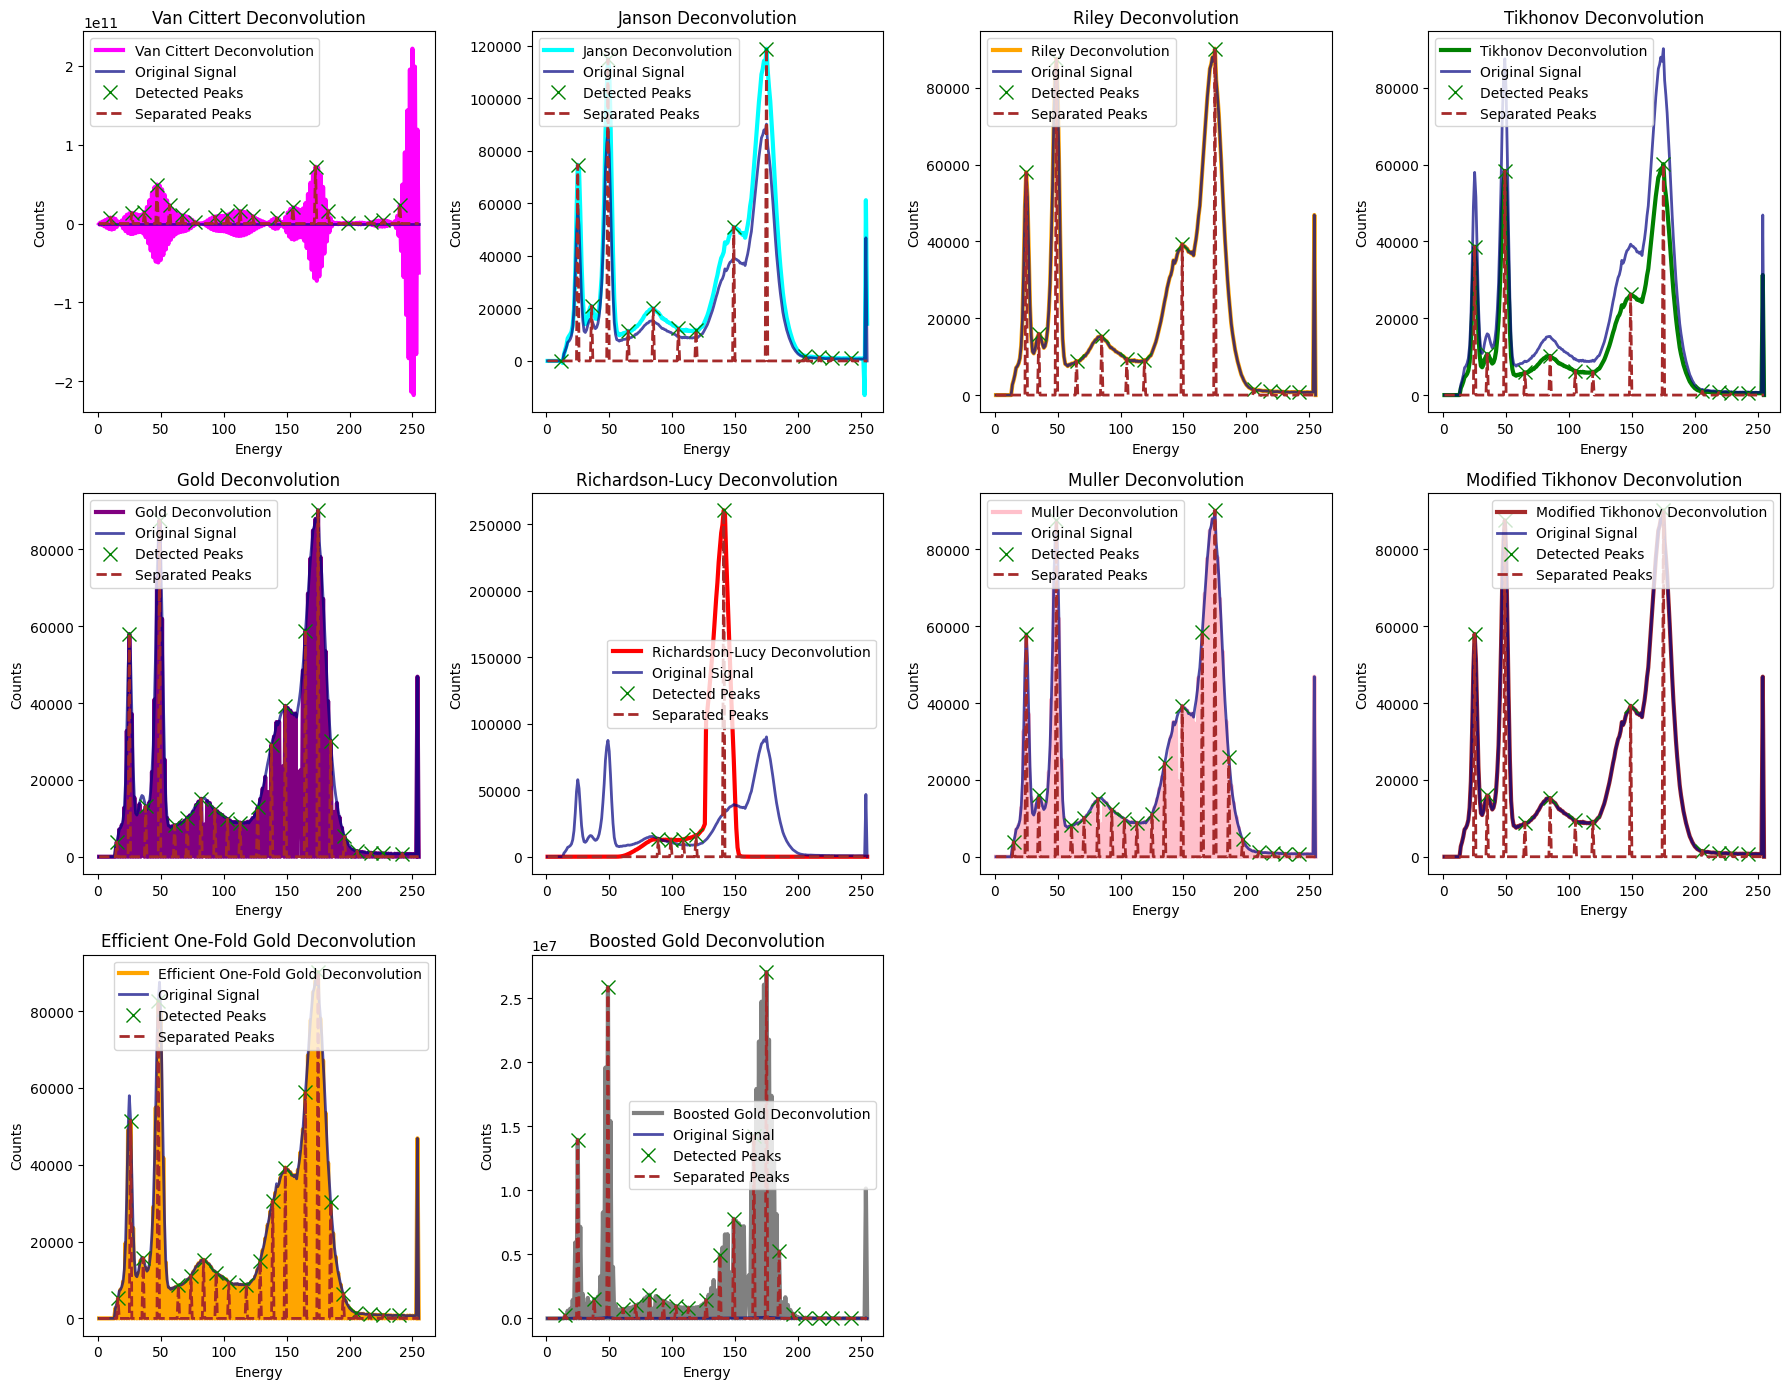

Van Cittert Peak Heights: [7.51366361e+09 1.34303888e+10 1.45857875e+10 4.94574399e+10
 2.32176542e+10 1.04341953e+10 2.23486869e+09 8.83036111e+09
 1.11644328e+10 1.57632576e+10 9.39265639e+09 6.85847329e+09
 2.04840962e+10 7.20729590e+10 1.63264985e+10 1.16532941e+09
 1.49148644e+09 3.95035109e+09 2.35451968e+10]
Janson Peak Heights: [1.64763311e+00 7.46667056e+04 2.08966752e+04 1.14892992e+05
 1.14893919e+04 2.00052343e+04 1.23926400e+04 1.18478385e+04
 5.10424410e+04 1.18875160e+05 1.98784553e+03 1.38985294e+03
 1.16361667e+03 1.04246967e+03]
Riley Peak Heights: [57958. 15943. 87517.  8841. 15257.  9458.  9097. 39272. 90156.  1491.
  1004.   861.   810.]
Tikhonov Peak Heights: [38638.66666667 10628.66666667 58344.66666667  5894.
 10171.33333333  6305.33333333  6064.66666667 26181.33333333
 60104.           994.           669.33333333   574.
   540.        ]
Gold Peak Heights: [ 3847 57957 13137 87516  8177 10190 15081 12324  9830  8905 12814 29166
 39271 58831 90155 30179  5270  14

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.linalg import solve

# Load data
data = pd.read_csv('15.5.csv')
energy = data.iloc[:, 0].values
counts = data.iloc[:, 1].values

# Define peak detection and separation
def detect_peaks(signal, height=None, distance=10, prominence=0.3):
    peaks, properties = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    return peaks, properties

def filter_end_peaks(peaks, signal_length, max_distance=10):
    return [peak for peak in peaks if peak < signal_length - max_distance]

def calculate_peak_properties(signal, peaks):
    peak_heights = signal[peaks]
    return peak_heights

def create_toeplitz_matrix(size):
    return np.array([[1 if abs(i-j) == 0 or abs(i-j) == 1 else 0 for j in range(size)] for i in range(size)])

def create_difference_matrix(size, order=1):
    if order == 1:
        Q = np.diag(np.ones(size-1), 1) - np.diag(np.ones(size-1), -1)
    elif order == 2:
        Q = np.diag(np.ones(size-2), 2) - 2 * np.diag(np.ones(size-1), 1) + np.diag(np.ones(size-2), -2)
    elif order == 3:
        Q = np.diag(np.ones(size-3), 3) - 3 * np.diag(np.ones(size-2), 2) + 3 * np.diag(np.ones(size-1), 1) - np.diag(np.ones(size-3), 0)
    return Q

def van_cittert_algorithm(H, y, iterations=10, mu=0.5):
    x = np.copy(y)
    E = np.eye(len(y))
    for _ in range(iterations):
        x = x + mu * (y - H @ x)
    return x

def janson_algorithm(H, y, iterations=10, mu=0.2, a=0, b=1):
    x = np.copy(y)
    for _ in range(iterations):
        E = np.eye(len(y))
        D = E - mu * H
        x = x + mu * (y - H @ x)
        mu = (a + b * np.linalg.norm(y - H @ x)) / (np.linalg.norm(H.T @ (y - H @ x)) ** 2)
    return x

def riley_algorithm(H, y, iterations=10, alpha=0.5):
    x = np.zeros_like(y)
    for _ in range(iterations):
        x = solve(H.T @ H + alpha * np.eye(len(H)), H.T @ y + alpha * x)
    return x

def tikhonov_regularization(H, y, alpha=0.5):
    x = solve(H.T @ H + alpha * np.eye(len(H)), H.T @ y)
    return x

def gold_algorithm(H, y, iterations=10, mu=0.5):
    x = np.copy(y)
    for _ in range(iterations):
        x_old = np.copy(x)
        for i in range(len(y)):
            sum_terms = np.sum(H[i, :] * x_old)
            x[i] = x_old[i] + mu * (y[i] - sum_terms)
        x = np.maximum(x, 0)  # Ensure non-negativity
    return x

def richardson_lucy_algorithm(H, y, iterations=10):
    x = np.copy(y)
    H_flipped = np.flip(H, axis=0)
    for _ in range(iterations):
        convolved = np.convolve(x, H_flipped, mode='same')
        ratio = y / (convolved + 1e-8)  # Add small value to avoid division by zero
        x = x * np.convolve(ratio, H, mode='same')
        x = np.maximum(x, 0)  # Ensure non-negativity
    return x

def muller_algorithm(H, y, iterations=10):
    M = len(y)
    N = len(H)
    x = np.copy(y)
    for _ in range(iterations):
        x_old = np.copy(x)
        for j in range(M):
            num = 0
            denom = 0
            for i in range(N):
                num += H[j, i] * x_old[i]
                denom += H[j, i] ** 2
            x[j] = x_old[j] * (y[j] / (num + 1e-8))  # Avoid division by zero
            x[j] = np.maximum(x[j], 0)  # Ensure non-negativity
    return x

def modified_tikhonov_algorithm(H, y, alpha=0.5, iterations=10):
    size = len(y)
    x = np.zeros_like(y)
    Q = np.zeros((size, size))

    for k in range(iterations):
        # Define Q0 as diagonal matrix with 1 for negative values in x
        Q0 = np.diag([1 if xi < 0 else 0 for xi in x])

        # Solve linear system with modified regularization
        A = H.T @ H + alpha * (Q0 + Q)
        b = H.T @ y
        x = solve(A, b)

        # Update y
        y = H @ x

    return x

def efficient_one_fold_gold_algorithm(H, y, iterations=10):
    size = len(y)
    x = np.ones(size)  # Initial estimate
    T = np.copy(H)  # Assuming H is a Toeplitz matrix
    for _ in range(iterations):
        d = T @ x
        for i in range(size):
            mu_i = 1 / (d[i] + 1e-8)  # Avoid division by zero
            x[i] = x[i] * (y[i] / (T[i, :] @ x + 1e-8))  # Avoid division by zero
            x[i] = np.maximum(x[i], 0)  # Ensure non-negativity
    return x

def boosted_deconvolution(H, y, base_algorithm, iterations=10, repetitions=5, boosting_coefficient=1.5):
    size = len(y)
    x = np.ones(size)  # Initial estimate

    for _ in range(repetitions):
        # Apply base deconvolution algorithm
        x = base_algorithm(H, y, iterations=iterations)

        # Boost the solution
        x = np.power(x, boosting_coefficient)  # Apply power function boosting

    return x

# Define matrices H for each method
H_van_cittert = create_toeplitz_matrix(len(counts))  # Toeplitz matrix for Van Cittert
H_janson = create_difference_matrix(len(counts), order=1)  # Difference matrix for Janson
H_riley = np.eye(len(counts))  # Identity matrix for Riley
H_tikhonov = np.eye(len(counts))  # Identity matrix for Tikhonov
H_gold = create_toeplitz_matrix(len(counts))  # Toeplitz matrix for Gold
H_richardson_lucy = np.ones(len(counts))  # Use a simple matrix for Richardson-Lucy (can be adjusted based on the data)
H_muller = create_toeplitz_matrix(len(counts))  # Toeplitz matrix for Muller
H_modified_tikhonov = np.eye(len(counts))  # Identity matrix for Modified Tikhonov
H_efficient_one_fold_gold = create_toeplitz_matrix(len(counts))  # Toeplitz matrix for Efficient One-Fold Gold

# Define parameters for each method
mu_van_cittert = 0.2
iterations_van_cittert = 100

mu_janson = 0.3
iterations_janson = 100
a_janson = 0
b_janson = 2

alpha_riley = 0.1
iterations_riley = 100

alpha_tikhonov = 0.5

mu_gold = 0.5
iterations_gold = 100

iterations_richardson_lucy = 100

iterations_muller = 100

alpha_modified_tikhonov = 0.5
iterations_modified_tikhonov = 100

iterations_efficient_one_fold_gold = 100

boosting_coefficient = 1.5
boosting_repetitions = 5

# Calculate Deconvolutions
background_van_cittert = van_cittert_algorithm(H_van_cittert, counts, iterations=iterations_van_cittert, mu=mu_van_cittert)
background_janson = janson_algorithm(H_janson, counts, iterations=iterations_janson, mu=mu_janson, a=a_janson, b=b_janson)
background_riley = riley_algorithm(H_riley, counts, iterations=iterations_riley, alpha=alpha_riley)
background_tikhonov = tikhonov_regularization(H_tikhonov, counts, alpha=alpha_tikhonov)
background_gold = gold_algorithm(H_gold, counts, iterations=iterations_gold, mu=mu_gold)
background_richardson_lucy = richardson_lucy_algorithm(H_richardson_lucy, counts, iterations=iterations_richardson_lucy)
background_muller = muller_algorithm(H_muller, counts, iterations=iterations_muller)
background_modified_tikhonov = modified_tikhonov_algorithm(H_modified_tikhonov, counts, alpha=alpha_modified_tikhonov, iterations=iterations_modified_tikhonov)
background_efficient_one_fold_gold = efficient_one_fold_gold_algorithm(H_efficient_one_fold_gold, counts, iterations=iterations_efficient_one_fold_gold)

# Apply Boosted Deconvolution
background_boosted_gold = boosted_deconvolution(H_gold, counts, gold_algorithm, iterations=iterations_gold, repetitions=boosting_repetitions, boosting_coefficient=boosting_coefficient)

# Detect peaks in each background signal
peaks_van_cittert, _ = detect_peaks(background_van_cittert, height=None, distance=10, prominence=0.3)
peaks_janson, _ = detect_peaks(background_janson, height=None, distance=10, prominence=0.3)
peaks_riley, _ = detect_peaks(background_riley, height=None, distance=10, prominence=0.3)
peaks_tikhonov, _ = detect_peaks(background_tikhonov, height=None, distance=10, prominence=0.3)
peaks_gold, _ = detect_peaks(background_gold, height=None, distance=10, prominence=0.3)
peaks_richardson_lucy, _ = detect_peaks(background_richardson_lucy, height=None, distance=10, prominence=0.3)
peaks_muller, _ = detect_peaks(background_muller, height=None, distance=10, prominence=0.3)
peaks_modified_tikhonov, _ = detect_peaks(background_modified_tikhonov, height=None, distance=10, prominence=0.3)
peaks_efficient_one_fold_gold, _ = detect_peaks(background_efficient_one_fold_gold, height=None, distance=10, prominence=0.3)
peaks_boosted_gold, _ = detect_peaks(background_boosted_gold, height=None, distance=10, prominence=0.3)

# Filter end peaks
filtered_peaks_van_cittert = filter_end_peaks(peaks_van_cittert, len(counts))
filtered_peaks_janson = filter_end_peaks(peaks_janson, len(counts))
filtered_peaks_riley = filter_end_peaks(peaks_riley, len(counts))
filtered_peaks_tikhonov = filter_end_peaks(peaks_tikhonov, len(counts))
filtered_peaks_gold = filter_end_peaks(peaks_gold, len(counts))
filtered_peaks_richardson_lucy = filter_end_peaks(peaks_richardson_lucy, len(counts))
filtered_peaks_muller = filter_end_peaks(peaks_muller, len(counts))
filtered_peaks_modified_tikhonov = filter_end_peaks(peaks_modified_tikhonov, len(counts))
filtered_peaks_efficient_one_fold_gold = filter_end_peaks(peaks_efficient_one_fold_gold, len(counts))
filtered_peaks_boosted_gold = filter_end_peaks(peaks_boosted_gold, len(counts))

# Create peak signal arrays for visualization
peak_signal_van_cittert = np.zeros_like(counts)
peak_signal_van_cittert[filtered_peaks_van_cittert] = background_van_cittert[filtered_peaks_van_cittert]

peak_signal_janson = np.zeros_like(counts)
peak_signal_janson[filtered_peaks_janson] = background_janson[filtered_peaks_janson]

peak_signal_riley = np.zeros_like(counts)
peak_signal_riley[filtered_peaks_riley] = background_riley[filtered_peaks_riley]

peak_signal_tikhonov = np.zeros_like(counts)
peak_signal_tikhonov[filtered_peaks_tikhonov] = background_tikhonov[filtered_peaks_tikhonov]

peak_signal_gold = np.zeros_like(counts)
peak_signal_gold[filtered_peaks_gold] = background_gold[filtered_peaks_gold]

peak_signal_richardson_lucy = np.zeros_like(counts)
peak_signal_richardson_lucy[filtered_peaks_richardson_lucy] = background_richardson_lucy[filtered_peaks_richardson_lucy]

peak_signal_muller = np.zeros_like(counts)
peak_signal_muller[filtered_peaks_muller] = background_muller[filtered_peaks_muller]

peak_signal_modified_tikhonov = np.zeros_like(counts)
peak_signal_modified_tikhonov[filtered_peaks_modified_tikhonov] = background_modified_tikhonov[filtered_peaks_modified_tikhonov]

peak_signal_efficient_one_fold_gold = np.zeros_like(counts)
peak_signal_efficient_one_fold_gold[filtered_peaks_efficient_one_fold_gold] = background_efficient_one_fold_gold[filtered_peaks_efficient_one_fold_gold]

peak_signal_boosted_gold = np.zeros_like(counts)
peak_signal_boosted_gold[filtered_peaks_boosted_gold] = background_boosted_gold[filtered_peaks_boosted_gold]

# Plotting the results
plt.figure(figsize=(18, 14))

# Van Cittert
plt.subplot(3, 4, 1)
plt.plot(energy, background_van_cittert, color='magenta', linewidth=3, label='Van Cittert Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_van_cittert], background_van_cittert[filtered_peaks_van_cittert], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_van_cittert, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Van Cittert Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Janson
plt.subplot(3, 4, 2)
plt.plot(energy, background_janson, color='cyan', linewidth=3, label='Janson Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_janson], background_janson[filtered_peaks_janson], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_janson, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Janson Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Riley
plt.subplot(3, 4, 3)
plt.plot(energy, background_riley, color='orange', linewidth=3, label='Riley Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_riley], background_riley[filtered_peaks_riley], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_riley, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Riley Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Tikhonov
plt.subplot(3, 4, 4)
plt.plot(energy, background_tikhonov, color='green', linewidth=3, label='Tikhonov Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_tikhonov], background_tikhonov[filtered_peaks_tikhonov], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_tikhonov, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Tikhonov Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Gold
plt.subplot(3, 4, 5)
plt.plot(energy, background_gold, color='purple', linewidth=3, label='Gold Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_gold], background_gold[filtered_peaks_gold], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_gold, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Gold Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Richardson-Lucy
plt.subplot(3, 4, 6)
plt.plot(energy, background_richardson_lucy, color='red', linewidth=3, label='Richardson-Lucy Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_richardson_lucy], background_richardson_lucy[filtered_peaks_richardson_lucy], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_richardson_lucy, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Richardson-Lucy Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Muller
plt.subplot(3, 4, 7)
plt.plot(energy, background_muller, color='pink', linewidth=3, label='Muller Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_muller], background_muller[filtered_peaks_muller], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_muller, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Muller Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Modified Tikhonov
plt.subplot(3, 4, 8)
plt.plot(energy, background_modified_tikhonov, color='brown', linewidth=3, label='Modified Tikhonov Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_modified_tikhonov], background_modified_tikhonov[filtered_peaks_modified_tikhonov], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_modified_tikhonov, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Modified Tikhonov Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Efficient One-Fold Gold
plt.subplot(3, 4, 9)
plt.plot(energy, background_efficient_one_fold_gold, color='orange', linewidth=3, label='Efficient One-Fold Gold Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_efficient_one_fold_gold], background_efficient_one_fold_gold[filtered_peaks_efficient_one_fold_gold], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_efficient_one_fold_gold, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Efficient One-Fold Gold Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Boosted Gold
plt.subplot(3, 4, 10)
plt.plot(energy, background_boosted_gold, color='grey', linewidth=3, label='Boosted Gold Deconvolution')
plt.plot(energy, counts, color='navy', alpha=0.7, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks_boosted_gold], background_boosted_gold[filtered_peaks_boosted_gold], 'x', color='green', markersize=10, label='Detected Peaks')
plt.plot(energy, peak_signal_boosted_gold, color='brown', linestyle='--', linewidth=2, label='Separated Peaks')
plt.title('Boosted Gold Deconvolution')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

plt.tight_layout()
plt.show()

# Print peak properties for analysis
print("Van Cittert Peak Heights:", calculate_peak_properties(background_van_cittert, filtered_peaks_van_cittert))
print("Janson Peak Heights:", calculate_peak_properties(background_janson, filtered_peaks_janson))
print("Riley Peak Heights:", calculate_peak_properties(background_riley, filtered_peaks_riley))
print("Tikhonov Peak Heights:", calculate_peak_properties(background_tikhonov, filtered_peaks_tikhonov))
print("Gold Peak Heights:", calculate_peak_properties(background_gold, filtered_peaks_gold))
print("Richardson-Lucy Peak Heights:", calculate_peak_properties(background_richardson_lucy, filtered_peaks_richardson_lucy))
print("Muller Peak Heights:", calculate_peak_properties(background_muller, filtered_peaks_muller))
print("Modified Tikhonov Peak Heights:", calculate_peak_properties(background_modified_tikhonov, filtered_peaks_modified_tikhonov))
print("Efficient One-Fold Gold Peak Heights:", calculate_peak_properties(background_efficient_one_fold_gold, filtered_peaks_efficient_one_fold_gold))
print("Boosted Gold Peak Heights:", calculate_peak_properties(background_boosted_gold, filtered_peaks_boosted_gold))
